In [16]:
%reload_ext autoreload
%autoreload 2

import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import statsmodels.api as sm
from lib import utils


plt.rcParams['font.family'] = 'times new roman'
plt.rcParams['font.size'] = 16

In [2]:
df = pd.read_csv('valid_sequence_data.csv',index_col=0)

In [18]:
# If data is clustered to three groups, one of these groups only has 9 subjects
# This explains why we only cluster subjects to two groups 
df_time_pivot_2 = df.pivot(index='worker_id', columns='reward', values='value_surplus')
kmeans = KMeans(n_clusters=3,random_state=42)
kmeans.fit(df_time_pivot_2.values)
print('Number of participants in each cluster:',np.bincount(kmeans.labels_))

Number of participants in each cluster: [110  46   1]


In [4]:
# Spearman rank-order correlation
# the entire sample
print(stats.spearmanr(df['value_surplus'],df['front_amount']))

# cluster 1
print(stats.spearmanr(df[df['label_kmeans'] == 0]['value_surplus'],
                df[df['label_kmeans'] == 0]['front_amount']))

# cluster 2
print(stats.spearmanr(df[df['label_kmeans'] == 1]['value_surplus'],
                    df[df['label_kmeans'] == 1]['front_amount']))

SignificanceResult(statistic=-0.043245998593847375, pvalue=0.04263276342226129)
SignificanceResult(statistic=-0.017606148185120487, pvalue=0.49998842410269084)
SignificanceResult(statistic=-0.18241995351590656, pvalue=7.227940717397807e-07)


In [5]:
df['front_amount_6m'] = df['front_amount'] * (df['seq_length'] == '6 months')
df['front_amount_12m'] = df['front_amount'] * (df['seq_length'] == '12 months')
df['front_amount_6m_0'] = df['front_amount_6m']  * (df['label_kmeans'] == 0)
df['front_amount_6m_1'] = df['front_amount_6m']  * (df['label_kmeans'] == 1)
df['front_amount_12m_0'] = df['front_amount_12m']  * (df['label_kmeans'] == 0)
df['front_amount_12m_1'] = df['front_amount_12m']  * (df['label_kmeans'] == 1)


df_dummy = pd.concat([df,pd.get_dummies(df['worker_id'], prefix='worker_id')],axis=1)
df_filtered = utils.rule_out_outlier(df_dummy,col_name='value_surplus')

reg_cols_baseline = ['front_amount_6m','front_amount_12m','choice_peli']
reg_cols_label = ['front_amount_6m_0','front_amount_12m_0','front_amount_6m_1','front_amount_12m_1','choice_peli']
reg_cols_dummy = reg_cols_baseline + [col for col in df_dummy.columns if col.startswith('worker_id_')]
reg_cols_dummy_2 = reg_cols_label + [col for col in df_dummy.columns if col.startswith('worker_id_')]


formula_pool_1 = 'value_surplus ~ front_amount_6m + front_amount_12m + choice_peli'
model_ols_pool_1 = sm.OLS.from_formula(formula_pool_1,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

Number of outliers (lower and upper): [4, 8]


In [6]:
formula_pool_2 = 'value_surplus ~ front_amount_6m_0 + front_amount_12m_0 + front_amount_6m_1 + front_amount_12m_1 + choice_peli'
model_ols_pool_2 = sm.OLS.from_formula(formula_pool_2,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

In [7]:
formula_fe = formula_pool_1 + '+C(worker_id)'
model_ols_fe = sm.OLS.from_formula(formula_fe,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

pd.concat([model_ols_fe.params[reg_cols_baseline].rename('coef'),
           model_ols_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_ols_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.005040,0.014359,-0.009075,-0.001005
front_amount_12m,-0.005306,0.009632,-0.009324,-0.001289
choice_peli,9.186859,0.000000,9.158254,9.215465


In [8]:
formula_fe_2 = formula_pool_2 + '+C(worker_id)'
model_ols_fe_2 = sm.OLS.from_formula(formula_fe_2,data=df_filtered).fit(
                                        cov_type='cluster',cov_kwds={'groups': df_filtered['worker_id']})

pd.concat([model_ols_fe_2.params[reg_cols_label].rename('coef'),
           model_ols_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_ols_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,0.001903,2.996807e-01,-0.001694,0.005500
front_amount_12m_0,0.002535,1.661264e-01,-0.001053,0.006123
front_amount_6m_1,-0.019018,1.111287e-05,-0.027501,-0.010536
front_amount_12m_1,-0.021080,3.064075e-07,-0.029151,-0.013010
choice_peli,7.215137,2.493699e-87,6.501246,7.929027


In [9]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_baseline]).astype(float)
model_rlm_pool_1 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())
model_rlm_pool_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2198
Model:                                                                            RLM   Df Residuals:                     2194
Method:                                                                          IRLS   Df Model:                            3
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000001DE4BAEFA90>                                         
Cov Type:                                                                          H1                                         
Date:                                                                Sun, 11 Feb 2024                                         
Time:                                                                        01:54:48                                         
No. Iterations:                                                                    12                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               55.0002      0.963     57.084      0.000      53.112      56.889
front_amount_6m     -0.0048      0.003     -1.920      0.055      -0.010       0.000
front_amount_12m    -0.0060      0.003     -2.397      0.017      -0.011      -0.001
choice_peli         -0.8484      0.861     -0.985      0.324      -2.536       0.839
====================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [10]:
y = df['value_surplus']
X = sm.add_constant(df[reg_cols_label]).astype(float)
model_rlm_pool_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())
model_rlm_pool_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            Robust linear Model Regression Results                                            
==============================================================================================================================
Dep. Variable:                                                          value_surplus   No. Observations:                 2198
Model:                                                                            RLM   Df Residuals:                     2192
Method:                                                                          IRLS   Df Model:                            5
Norm:                                                                          HuberT                                         
Scale Est.:        <statsmodels.robust.scale.HuberScale object at 0x000001DE4BAC3DD0>                                         
Cov Type:                                                                          H1                                         
Date:                                                                Sun, 11 Feb 2024                                         
Time:                                                                        01:54:49                                         
No. Iterations:                                                                    18                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 55.8293      0.717     77.902      0.000      54.425      57.234
front_amount_6m_0      0.0148      0.002      7.171      0.000       0.011       0.019
front_amount_12m_0     0.0145      0.002      7.050      0.000       0.010       0.019
front_amount_6m_1     -0.0614      0.003    -24.078      0.000      -0.066      -0.056
front_amount_12m_1    -0.0666      0.003    -26.107      0.000      -0.072      -0.062
choice_peli           -1.0143      0.640     -1.584      0.113      -2.270       0.241
======================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [11]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy]).astype(float)
model_rlm_fe = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())

pd.concat([model_rlm_fe.params[reg_cols_baseline].rename('coef'),
           model_rlm_fe.pvalues[reg_cols_baseline].rename('pvalues'),
           model_rlm_fe.conf_int().loc[reg_cols_baseline].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m,-0.004768,1.405737e-06,-0.006705,-0.002831
front_amount_12m,-0.006412,8.714686e-11,-0.008349,-0.004475
choice_peli,2.181327,7.852493e-12,1.556390,2.806263


In [12]:
y = df_dummy['value_surplus']
X = sm.add_constant(df_dummy[reg_cols_dummy_2]).astype(float)
model_rlm_fe_2 = sm.RLM(endog=y,exog=X,M=sm.robust.norms.HuberT()).fit(maxiter=200,scale_est=sm.robust.scale.HuberScale())

pd.concat([model_rlm_fe_2.params[reg_cols_label].rename('coef'),
           model_rlm_fe_2.pvalues[reg_cols_label].rename('pvalues'),
           model_rlm_fe_2.conf_int().loc[reg_cols_label].rename(columns={0:'ci_lower',1:'ci_upper'})],
           axis=1)

,coef,pvalues,ci_lower,ci_upper
front_amount_6m_0,0.000075,9.490699e-01,-0.002227,0.002377
front_amount_12m_0,-0.000382,7.450786e-01,-0.002683,0.001920
front_amount_6m_1,-0.017401,1.850390e-25,-0.020672,-0.014130
front_amount_12m_1,-0.022004,1.056333e-39,-0.025274,-0.018733
choice_peli,2.206247,1.084793e-12,1.598860,2.813634


NormaltestResult(statistic=1408.0328798960743, pvalue=1.7764171666885885e-306)


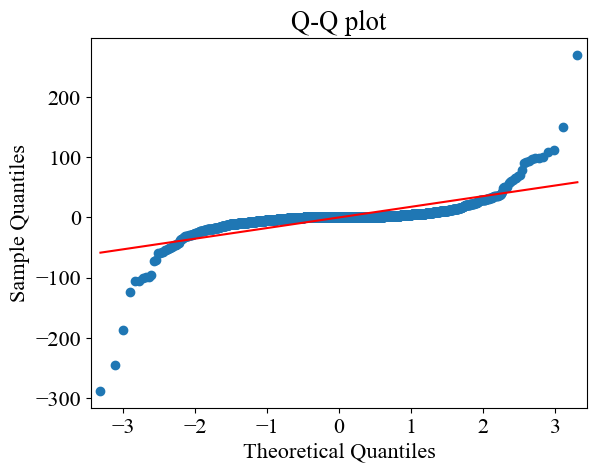

In [13]:
pplot = sm.ProbPlot(model_rlm_fe_2.resid)
fig = pplot.qqplot(line='s')
plt.title('Q-Q plot')
print(stats.normaltest(model_rlm_fe_2.resid))

In [14]:
# save regression results
model_results = {'ols_pool_baseline':utils.get_reg_result(model_ols_pool_1,reg_cols_baseline),
                 'ols_pool_label':utils.get_reg_result(model_ols_pool_2,reg_cols_label),
                 'ols_fe_baseline':utils.get_reg_result(model_ols_fe,reg_cols_baseline),
                 'ols_fe_label':utils.get_reg_result(model_ols_fe_2,reg_cols_label),
                 'rlm_pool_baseline':utils.get_reg_result(model_rlm_pool_1,reg_cols_baseline),
                 'rlm_pool_label':utils.get_reg_result(model_rlm_pool_2,reg_cols_label),
                 'rlm_fe_baseline':utils.get_reg_result(model_rlm_fe,reg_cols_baseline),
                 'rlm_fe_label':utils.get_reg_result(model_rlm_fe_2,reg_cols_label)
                 }

with open('model_reg_result_k.json', "w") as f:
    json.dump(model_results, f)

In [15]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_1,param_names=reg_cols_baseline,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_baseline_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

 18%|█▊        | 178/1000 [00:09<00:43, 19.08it/s]


TypeError: 'RLMResultsWrapper' object is not subscriptable

In [ ]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_pool_2,param_names=reg_cols_label,n_bootstrap=1000)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_pool_label_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [00:26<00:00, 37.91it/s]


In [ ]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe,param_names=reg_cols_baseline,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_baseline_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [32:15<00:00,  1.94s/it]


In [ ]:
model_bootstrap = utils.bootstrap_model(df,model=model_rlm_fe_2,param_names=reg_cols_label,n_bootstrap=1000,fe=True)
model_bootstrap.bootstrap()
with open('bootstrap_rlm_fe_label_k.pkl', 'wb') as file:
    pickle.dump(model_bootstrap, file)

100%|██████████| 1000/1000 [33:12<00:00,  1.99s/it]
